In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import normalize, MinMaxScaler

In [3]:
dftest1 = pd.read_csv("vh_vv_data_new_20.csv").drop("Unnamed: 0", axis =1)
dftest2 = pd.read_csv("vh_vv_data_new_20_100.csv").drop("Unnamed: 0", axis =1)
dftest3 = pd.read_csv("vh_vv_data_new_100_200.csv").drop("Unnamed: 0", axis =1)
dftest4 = pd.read_csv("vh_vv_data_new_200_225.csv").drop("Unnamed: 0", axis =1)
dftest5 = pd.read_csv("vh_vv_data_new_225_300.csv").drop("Unnamed: 0", axis =1)
dftest6 = pd.read_csv("vh_vv_data_new_300_350.csv").drop("Unnamed: 0", axis =1)
dftest7 = pd.read_csv("vh_vv_data_new_350_400.csv").drop("Unnamed: 0", axis =1)
dftest8 = pd.read_csv("vh_vv_data_new_400_450.csv").drop("Unnamed: 0", axis =1)
dftest9 = pd.read_csv("vh_vv_data_new_450_500.csv").drop("Unnamed: 0", axis =1)
dftest10 = pd.read_csv("vh_vv_data_new_500_557.csv").drop("Unnamed: 0", axis =1)
dftest = pd.concat([dftest1,dftest2,dftest3,dftest4, dftest5,dftest6, dftest7, dftest8, dftest9,dftest10])

### Prepare data

In [4]:
def clean_from_df_pad(string):
    """
    takes in each cell as a string and replaces it with an array of float value. 
    Also pads the sequence to length 26
    """
    splitted = string.split(" ")
    result = []
    for i in splitted:
        number = float(i.replace(",","").replace("[", "").replace("]", ""))
        result.append(number)
    if len(result) !=26:
        missing = 26-len(result)
        comp = [0] * missing
        result = result + comp
    return np.asarray(result)

In [5]:
# read in those dataframes again before this
dftest["vv_list"] = dftest.vv_list.apply(clean_from_df_pad)
dftest["vh_list"] = dftest.vh_list.apply(clean_from_df_pad)
dftest['vv/vh_list'] = dftest['vv/vh_list'].apply(clean_from_df_pad)

In [6]:
# add a climate index called rvi
def calculate_rvi(vv, vh):
    """
    takes in a list of vvs and a list of vhs, return a list of their rvis
    dop = vv/(vv+vh)
    m = 1-dop
    m = np.sqrt(m)
    power_func = 4*vh/(vv+vh)
    rvi = m*power_func
    """
    if len(vv)!= len(vh):
        return None
    else:
        rvi_lst = []
        for i in range(len(vv)):
            rvi = np.sqrt(1-vv[i]/(vv[i]+vh[i])) * 4*vh[i]/(vv[i]+vh[i])
            rvi_lst.append(rvi)
    return rvi_lst

calculate_rvi_func = np.vectorize(calculate_rvi)

In [7]:
dftest["rvi"] = calculate_rvi(list(dftest.vv_list), list(dftest.vh_list))

In [8]:
# length is equal
def df_to_arr_equal_len (df):
    """
    takes in a df, which will be data, and transforms it into a 3-d array with its original size
    """
    # loop through every row in df
    res = []
    for i in range(df.shape[0]):
        row = list(df.iloc[i,:]) # each row of df is turned into a list of three elements, where each element is an array
        new_row = [] # one day, one location, three variables
        for var in row:
            new_row.append(var)
        res.append(new_row)
    return np.asarray(res)

In [9]:
arr = df_to_arr_equal_len(dftest)
np.isnan(arr).sum()

2504

In [10]:
# replace null rvi's with 0
arr = np.nan_to_num(arr, nan=0)
np.isnan(arr).sum()

0

In [11]:
arr.shape

(557, 4, 26)

In [14]:
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:])
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(x, batch_size=50, shuffle=True)

In [15]:
x.shape

torch.Size([500, 4, 26])

In [16]:
y = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"]))

# use the first 500 samples to train
input = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
target = y[:500].float().view(500)

In [17]:
input.shape

torch.Size([500, 26, 4])

In [22]:
# create your dataset
training_dataset = MyDataset(input, target)

# create your dataloader
train_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

____
### Baseline GRU with batch norm

### NOTE: the following models are trained on the dataset with sequence length 26 (zero-padded)

In [18]:
# get gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [48]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, 
                 batch_first, batch_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, 
                  batch_first=True, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(num_features=self.hidden_size, affine = False)
        #### should this be batch size, hidden size, feature size, sequence length?
            # feature size doesn't work, 
            # sequence length will cause error "RuntimeError: running_mean should contain 20 elements not 26"
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.randn(self.gru.num_layers, batch_size, self.gru.hidden_size).to(x.device)
        #h0 = torch.randn(1, self.batch_size, self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        #### h0 = h0[0,:,:].unsqueeze(0) # (num_layers, batch_size, hidden_size) -> (1, batch_size, hidden_size)
            # this didn't work
        out, _ = self.gru(x, h0)
        out = self.bn(out[:,-1, :])
        out = self.fc(out)
        return out

In [50]:
# Define the loss function and optimizer
criterion = nn.L1Loss()
model = GRU(input_size=4, hidden_size=200, output_size = 1,num_layers=5, 
                 batch_first=True, batch_size = 50)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)

# Train the model
num_epochs = 1000
print_iters = 55
batch_freq = 4
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.view(50, 26, 4).to(device)
        # gru parameter: input should have shape batch_size, sequence_length, num_features
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch% print_iters ==1 and i% batch_freq ==1:
            print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, total_loss / len(train_dataloader)))
    losses.append(total_loss/ len(train_dataloader))
print("Finished training")

Epoch [2/1000], Loss: 1320.0322
Epoch [2/1000], Loss: 3958.2167
Epoch [2/1000], Loss: 6614.2812
Epoch [57/1000], Loss: 1224.4326
Epoch [57/1000], Loss: 3696.2579
Epoch [57/1000], Loss: 6174.2832
Epoch [112/1000], Loss: 1149.7539
Epoch [112/1000], Loss: 3453.8219
Epoch [112/1000], Loss: 5734.2899
Epoch [167/1000], Loss: 1048.8725
Epoch [167/1000], Loss: 3157.6175
Epoch [167/1000], Loss: 5295.2764
Epoch [222/1000], Loss: 984.5550
Epoch [222/1000], Loss: 2930.8249
Epoch [222/1000], Loss: 4854.2949
Epoch [277/1000], Loss: 898.5139
Epoch [277/1000], Loss: 2682.5417
Epoch [277/1000], Loss: 4414.2895
Epoch [332/1000], Loss: 804.1498
Epoch [332/1000], Loss: 2355.1701
Epoch [332/1000], Loss: 3974.2704
Epoch [387/1000], Loss: 714.2304
Epoch [387/1000], Loss: 2123.6511
Epoch [387/1000], Loss: 3534.2718
Epoch [442/1000], Loss: 596.7927
Epoch [442/1000], Loss: 1817.5820
Epoch [442/1000], Loss: 3094.2871
Epoch [497/1000], Loss: 526.0288
Epoch [497/1000], Loss: 1600.8463
Epoch [497/1000], Loss: 2654.

In [81]:
losses[-1]

674.1056335449218

Baseline GRU with batch_size=50, hidden_size = 200, optimizer = Adam, lr = 0.8, num_layers=5


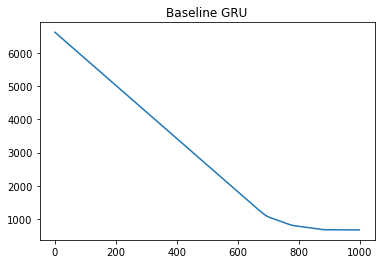

In [51]:
print("Baseline GRU with batch_size=50, hidden_size = 200, optimizer = Adam, lr = 0.8, num_layers=5")
plt.plot(range(len(losses)), losses)
plt.title("Baseline GRU")
plt.show()

In [52]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = model(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(729.2120, device='cuda:0', grad_fn=<MeanBackward0>)


---
#### Improve this GRU by adding activation, changing to SGD optimizer

In [46]:
# Define the loss function and optimizer
criterion = nn.L1Loss()
mod1 = GRU(input_size=4, hidden_size=200, output_size = 1, num_layers=6, 
                 batch_first=True, batch_size = 50)
mod1.to(device)
optimizer = torch.optim.SGD(mod1.parameters(), lr=0.04, momentum = 0.9)

# Train the model
num_epochs = 1000
print_iters = 55
batch_freq = 4
loss1 = []
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.view(50, 26, 4).to(device)
        # gru parameter: input should have shape batch_size, sequence_length, num_features
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = mod1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch% print_iters ==1 and i% batch_freq ==1:
            print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, total_loss / len(train_dataloader)))
    loss1.append(total_loss/ len(train_dataloader))
print("Finished training")

Epoch [2/1000], Loss: 1307.5841
Epoch [2/1000], Loss: 3933.3662
Epoch [2/1000], Loss: 6526.9210
Epoch [57/1000], Loss: 387.7073
Epoch [57/1000], Loss: 1119.7736
Epoch [57/1000], Loss: 1878.7302
Epoch [112/1000], Loss: 200.2980
Epoch [112/1000], Loss: 592.8618
Epoch [112/1000], Loss: 977.2992
Epoch [167/1000], Loss: 184.0858
Epoch [167/1000], Loss: 580.6231
Epoch [167/1000], Loss: 955.3699
Epoch [222/1000], Loss: 186.2587
Epoch [222/1000], Loss: 547.1554
Epoch [222/1000], Loss: 934.5328
Epoch [277/1000], Loss: 185.7687
Epoch [277/1000], Loss: 556.6671
Epoch [277/1000], Loss: 946.9944
Epoch [332/1000], Loss: 177.2345
Epoch [332/1000], Loss: 560.1701
Epoch [332/1000], Loss: 897.5807
Epoch [387/1000], Loss: 190.1928
Epoch [387/1000], Loss: 558.2585
Epoch [387/1000], Loss: 912.7837
Epoch [442/1000], Loss: 183.6274
Epoch [442/1000], Loss: 546.1960
Epoch [442/1000], Loss: 915.4163
Epoch [497/1000], Loss: 178.6557
Epoch [497/1000], Loss: 531.0974
Epoch [497/1000], Loss: 891.8624
Epoch [552/100

GRU with batch_size=50, hidden_size = 200, optimizer = SGD, lr = 0.045, momentum=0.9 num_layers=7


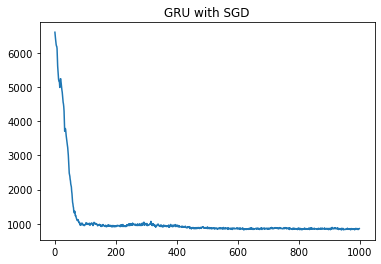

In [47]:
print("GRU with batch_size=50, hidden_size = 200, optimizer = SGD, lr = 0.045, momentum=0.9 num_layers=7")
plt.plot(range(len(loss1)), loss1) 
plt.title("GRU with SGD")
plt.show()

In [53]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = mod1(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(880.8220, device='cuda:0', grad_fn=<MeanBackward0>)


----
#### Improve GRU by changing batch size to 25, dropout to 0.1, removing ReLU 
## This seems to be the best!

In [54]:
train_dataloader = DataLoader(training_dataset, batch_size=25, shuffle=True)

In [21]:
class GRU2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, 
                 batch_first, batch_size):
        super(GRU2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, 
                  batch_first=True, dropout=0.1, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(num_features=self.hidden_size, affine = False)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.randn(self.gru.num_layers, batch_size, self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out, _ = self.gru(x, h0)
        out = self.bn(out[:,-1, :])
        out = self.fc(out)
        return out

In [62]:
# Define the loss function and optimizer
mod2 = GRU2(input_size=4, hidden_size=100, output_size = 1, num_layers=5, 
                 batch_first=True, batch_size =25)
mod2.to(device)
optimizer = torch.optim.SGD(mod2.parameters(), lr=0.0352, momentum = 0.9)

# Train the model
num_epochs = 1300
print_iters = 75
batch_freq = 7
loss2 = []
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.view(25, 26, 4).to(device)
        # gru parameter: input should have shape batch_size, sequence_length, num_features
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = mod2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch% print_iters ==1 and i% batch_freq ==1:
            print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, total_loss / len(train_dataloader)))
    loss2.append(total_loss/ len(train_dataloader))
print("Finished training")

Epoch [2/1300], Loss: 656.1954
Epoch [2/1300], Loss: 2956.5318
Epoch [2/1300], Loss: 5303.0082
Epoch [77/1300], Loss: 586.7127
Epoch [77/1300], Loss: 2754.3728
Epoch [77/1300], Loss: 4876.4104
Epoch [152/1300], Loss: 550.3136
Epoch [152/1300], Loss: 2495.5368
Epoch [152/1300], Loss: 4448.4974
Epoch [227/1300], Loss: 527.2260
Epoch [227/1300], Loss: 2278.8225
Epoch [227/1300], Loss: 4039.9564
Epoch [302/1300], Loss: 468.3384
Epoch [302/1300], Loss: 2046.6283
Epoch [302/1300], Loss: 3590.5356
Epoch [377/1300], Loss: 411.4908
Epoch [377/1300], Loss: 1788.2740
Epoch [377/1300], Loss: 3186.3947
Epoch [452/1300], Loss: 345.5231
Epoch [452/1300], Loss: 1560.0797
Epoch [452/1300], Loss: 2768.9737
Epoch [527/1300], Loss: 287.9155
Epoch [527/1300], Loss: 1322.8054
Epoch [527/1300], Loss: 2351.2728
Epoch [602/1300], Loss: 231.7879
Epoch [602/1300], Loss: 1066.6111
Epoch [602/1300], Loss: 1900.6519
Epoch [677/1300], Loss: 187.7003
Epoch [677/1300], Loss: 822.1769
Epoch [677/1300], Loss: 1478.5909


In [80]:
loss2[-1]

673.7685028076172

GRU with batch_size=25, hidden_size = 100, optimizer = SGD, lr = 0.035, momentum=0.9 num_layers=5


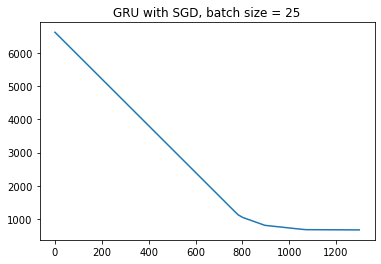

In [65]:
print("GRU with batch_size=25, hidden_size = 100, optimizer = SGD, lr = 0.035, momentum=0.9 num_layers=5")
plt.plot(range(len(loss2)), loss2) 
plt.title("GRU with SGD, batch size = 25")
plt.show()

In [66]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = mod2(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(725.9825, device='cuda:0', grad_fn=<MeanBackward0>)


----
#### Further miprove GRU performance by changing batch size to 10 / to 5 and num_layers to 4 --- only minimally better than mod2

In [19]:
train_dataloader = DataLoader(training_dataset, batch_size=10, shuffle=True)

In [25]:
# Define the loss function and optimizer
mod3 = GRU2(input_size=4, hidden_size=100, output_size = 1, num_layers=10, 
                 batch_first=True, batch_size =10)
mod3.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(mod3.parameters(), lr=0.01, momentum = 0.9)

# Train the model
num_epochs = 2000
print_iters = 55
batch_freq = 21
loss3 = []
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.view(10, 26, 4).to(device)
        # gru parameter: input should have shape batch_size, sequence_length, num_features
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = mod3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch% print_iters ==1 and i% batch_freq ==1:
            print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, total_loss / len(train_dataloader)))
    loss3.append(total_loss/ len(train_dataloader))
print("Finished training")

Epoch [2/2000], Loss: 250.3129
Epoch [2/2000], Loss: 3031.5971
Epoch [2/2000], Loss: 5813.2399
Epoch [57/2000], Loss: 248.9128
Epoch [57/2000], Loss: 2902.4143
Epoch [57/2000], Loss: 5573.6338
Epoch [112/2000], Loss: 237.8326
Epoch [112/2000], Loss: 2791.8726
Epoch [112/2000], Loss: 5335.1909
Epoch [167/2000], Loss: 229.9553
Epoch [167/2000], Loss: 2671.4035
Epoch [167/2000], Loss: 5099.3300
Epoch [222/2000], Loss: 210.8380
Epoch [222/2000], Loss: 2543.6145
Epoch [222/2000], Loss: 4860.9891
Epoch [277/2000], Loss: 207.0407
Epoch [277/2000], Loss: 2438.4653
Epoch [277/2000], Loss: 4607.1682
Epoch [332/2000], Loss: 207.6434
Epoch [332/2000], Loss: 2320.9962
Epoch [332/2000], Loss: 4375.9873
Epoch [387/2000], Loss: 183.7661
Epoch [387/2000], Loss: 2178.3271
Epoch [387/2000], Loss: 4117.5664
Epoch [442/2000], Loss: 177.6412
Epoch [442/2000], Loss: 2037.6100
Epoch [442/2000], Loss: 3902.0958
Epoch [497/2000], Loss: 170.3104
Epoch [497/2000], Loss: 1907.9864
Epoch [497/2000], Loss: 3622.3396

GRU with batch_size=10, hidden_size = 100, optimizer = SGD, lr = 0.03, momentum=0.9 num_layers=10
Last trainig error:  673.7641583251954


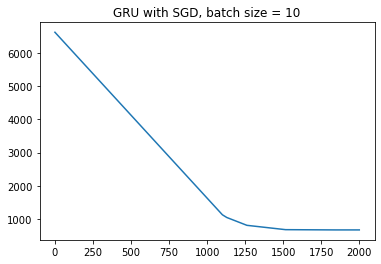

In [27]:
print("GRU with batch_size=10, hidden_size = 100, optimizer = SGD, lr = 0.01, momentum=0.9 num_layers=10")
print("Last trainig error: ", loss3[-1])
plt.plot(range(len(loss3)), loss3) 
plt.title("GRU with SGD, batch size = 10")
plt.show()

In [28]:
# evaluate model on the rest 57 points
# see test performance
testing = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y_true = torch.from_numpy(np.asarray(pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"]))
testing = testing.to(device)
y_true = y_true.to(device)
predicted = mod3(testing).view(57)
print("Testing error(L1):",  criterion(predicted, y_true))

Testing error(L1): tensor(725.9494, device='cuda:0', grad_fn=<MeanBackward0>)


______
### Helper functions

In [13]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [148]:
input = input.to(device)
target = target.to(device)